In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

2025-02-20 12:10:18.713159: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-20 12:10:19.148497: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-20 12:10:19.521804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740053419.815303    1062 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740053419.897450    1062 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 12:10:20.627149: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
df = pd.read_csv("../data/brent_oil_cleaned.csv", parse_dates=["Date"])

/home/user/Change-point-analysis-and-statistical-modelling-of-time-series-data/.env/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006377. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 4.163647901481381e+20
Iteration:      2,   Func. Count:     18,   Neg. LLF: -22207.181733213212
Optimization terminated successfully    (Exit mode 0)
            Current function value: -22207.18174392776
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


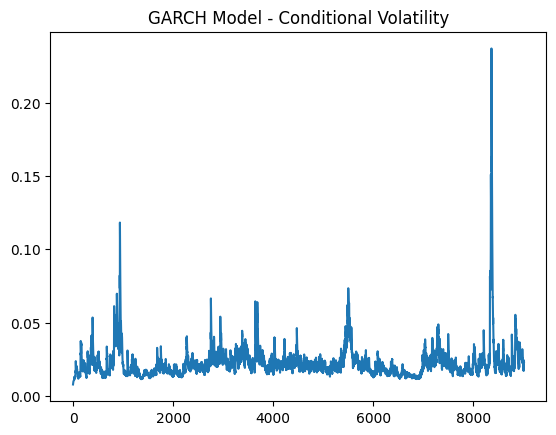

In [3]:
garch = arch_model(df["Returns"].dropna(), vol="Garch", p=1, q=1)
garch_fit = garch.fit()

# Plot volatility forecast
plt.plot(garch_fit.conditional_volatility)
plt.title("GARCH Model - Conditional Volatility")
plt.show()

In [6]:
model = ARIMA(df["Price"], order=(5,1,0))
model_fit = model.fit()

# Forecast next 30 days
forecast = model_fit.forecast(steps=30)
print(forecast)

9011    93.392185
9012    93.470938
9013    93.536262
9014    93.477045
9015    93.476757
9016    93.479749
9017    93.481342
9018    93.479974
9019    93.480029
9020    93.480111
9021    93.480145
9022    93.480113
9023    93.480115
9024    93.480117
9025    93.480118
9026    93.480117
9027    93.480117
9028    93.480117
9029    93.480117
9030    93.480117
9031    93.480117
9032    93.480117
9033    93.480117
9034    93.480117
9035    93.480117
9036    93.480117
9037    93.480117
9038    93.480117
9039    93.480117
9040    93.480117
Name: predicted_mean, dtype: float64


In [8]:
# Compute metrics
rmse = np.sqrt(mean_squared_error(df["Price"][-30:], forecast))
mae = mean_absolute_error(df["Price"][-30:], forecast)
r2 = r2_score(df["Price"][-30:], forecast)

print(f"ARIMA Model Performance - RMSE: {rmse}, MAE: {mae}, R²: {r2}")

ARIMA Model Performance - RMSE: 2.6320300024096452, MAE: 2.0516119498986254, R²: -0.10953159612243857


In [9]:
# Prepare data for LSTM
lookback = 30  # Use last 30 days for prediction
X, y = [], []
for i in range(lookback, len(df["Price"])):
    X.append(df["Price"][i-lookback:i])
    y.append(df["Price"][i])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM

# Build LSTM model
model = Sequential([
    LSTM(50, activation="relu", return_sequences=True, input_shape=(lookback, 1)),
    LSTM(50, activation="relu"),
    Dense(1)
])

# Compile and train
model.compile(optimizer="adam", loss="mse")
model.fit(X, y, epochs=20, batch_size=16)

# Predict next 30 days
predictions = model.predict(X[-30:])
print(predictions)

2025-02-20 12:20:48.370685: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/user/Change-point-analysis-and-statistical-modelling-of-time-series-data/.env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 7090.7368
Epoch 2/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 83.0192
Epoch 3/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 13.3369
Epoch 4/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 9.6549
Epoch 5/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 8.0263
Epoch 6/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 7.5609
Epoch 7/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 7.7621
Epoch 8/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 7.1538
Epoch 9/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 6.7100
Epoch 10/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 7.1439
Epoch 11/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 7.6711
Epoch 12/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 6.4360
Epoch 13/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 7.2340
Epoch 14/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 6.1253
Epoch 15/20
562/562 ━━━━

In [10]:
# Compute metrics
rmse = np.sqrt(mean_squared_error(df["Price"][-30:], predictions))
mae = mean_absolute_error(df["Price"][-30:], predictions)
r2 = r2_score(df["Price"][-30:], predictions)

print(f"LSTM Model Performance - RMSE: {rmse}, MAE: {mae}, R²: {r2}")

LSTM Model Performance - RMSE: 3.3272101018285314, MAE: 2.8805575663248697, R²: -0.7730396799537869
